# EnvErgo project
- [researchgate link](https://www.researchgate.net/project/Isokinetic-measurements-and-musculoskeletal-modelling-for-ergonomics)
- [github link](https://github.com/romainmartinez/envergo)

_Romain Martinez_

# Statistical Parametric Mapping

In [1]:
import envergo
import os
import scipy.io as sio
import numpy as np; np.random.seed(0)
import spm1d
import itertools
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
data_path = '/home/romain/Downloads/envergo/meshdata/'
files = os.listdir(data_path)

torque = {}

for ifile in files:
    if ifile.endswith('meshdata.mat'):
        participant, position, contraction, ext = ifile.split('_')

        mat = sio.loadmat(os.path.join(data_path, ifile))['Torque4mesh']
        if not position in torque:
            torque[position] = {}
        if contraction in torque[position]:
            torque[position][contraction] = np.dstack((torque[position][contraction], mat))
        else:
            torque[position][contraction] = mat

In [3]:
# create spm matrix (flatten 2D matrix to 1D vector)
contraction = 'Ext'
angle, velocity, participant = torque['Ref'][contraction].shape
position = len(torque.keys())
angle = np.arange(20, 140+3, 3)
velocity = np.arange(-180, 185, 5)

participants, positions, y = ([] for i in range(3))

for iparticipant in range(participant):
    for iposition, position_name in enumerate(torque.keys()):
        participants.append(iparticipant)
        positions.append(iposition)
        if iparticipant >= torque[position_name][contraction].shape[2]:
            print('position {} participant {} is nan'.format(position_name, iparticipant))
            # replace missing trial by nan
            y.append(np.full(y[-1].shape[0], np.nan))
        else:
            y.append(torque[position_name][contraction][:, :, iparticipant - 1].flatten())

participants, positions, y = [np.array(i) for i in [participants, positions, y]]
print('----dimension----'.upper())
print('participant: {}'.format(participants.shape))
print('position: {}'.format(positions.shape))
print('y.shape: {}'.format(y.shape))

position Flex180ER participant 31 is nan
position Flex180ER participant 32 is nan
position Flex180ER participant 33 is nan
position Abd90IR participant 33 is nan
----DIMENSION----
participant: (204,)
position: (204,)
y.shape: (204, 2993)


In [4]:
# replace missing trial by mean of the position
for iposition in np.unique(positions):
    idx = positions == iposition
    mean_vector = np.nanmean(y[idx, :], axis=0)
    y[idx, :] = np.where(np.isnan(y[idx, :]), mean_vector, y[idx, :])

In [5]:
def display_results(spm, drop_non_significative=False, title=None,
                    print_result=True, get_roi=False, save_fig=False, 
                    colors=None, diff=None):
    rows, columns = 41, 73
    
    if print_result:
        print(spm)
        print(spm.clusters)
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    
    # 1D representation
    spm.plot(ax=axs[0])
    #spm.plot_p_values(ax=axs[0])
    #spm.plot_threshold_label(ax=axs[0])
    axs[0].set_title('1D representation')
    
    signi = np.abs(spm.z) >= spm.zstar
    
    if get_roi:
        roi = signi
    else:
        roi = None
    
    # 2D representation
    z = spm.z.reshape([rows, columns])
    
    if diff is None:
        # plot the statistical value
        d = z
    else:
        # plot the difference (only valid for posthoc)
        d = diff.reshape([rows, columns])
        
    if drop_non_significative:
        spm.z[~signi] = np.nan
        # assign white to nan
        plot_array = np.ma.masked_where(np.isnan(z),d)
    else:
        plot_array = d
    
    if colors:
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
        plt.pcolormesh(velocity, angle, plot_array, vmin=-30, vmax=30,
                   cmap=cmap, antialiased=True)
    else:
        cmap='viridis'
        plt.pcolormesh(velocity, angle, plot_array, vmin=3, vmax=15,
                   cmap=cmap, antialiased=True)

    # float to int
    envergo.util.axis2int()
    # add color bar
    plt.colorbar(pad=.08)
    
    plt.xlabel('Velocity')
    plt.ylabel('Angle')
    
    axs[1].set_title('2D representation')
    
    # aes
    fig.tight_layout()
    fig.suptitle(title, y=1.05, fontsize=15)
    plt.show()
    
    if save_fig:
        fig.savefig('./share/fig/{}.pdf'.format(title), transparent=True)
    return roi

## One-way repeated-measures ANOVA (non-parametric)

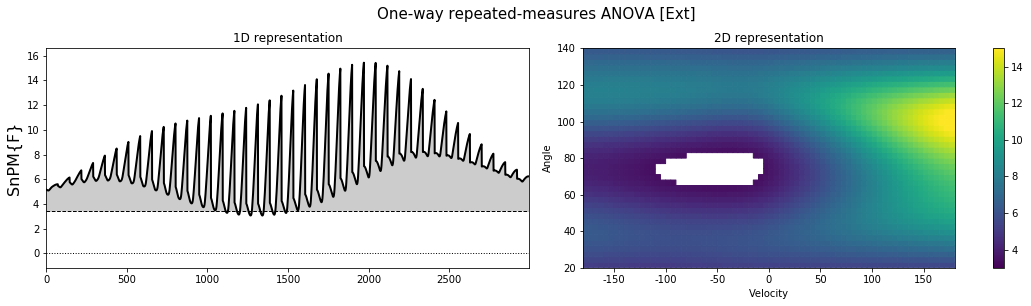

In [6]:
alpha = 0.05
iterations = 10000
np.random.seed(0)

a_spm = spm1d.stats.nonparam.anova1rm(y, positions, participants)
a_spmi = a_spm.inference(alpha, iterations=iterations)

title = 'One-way repeated-measures ANOVA [{}]'.format(contraction)
roi = display_results(a_spmi, drop_non_significative=True, title=title, print_result=False, get_roi=True, save_fig=True)

## Post hoc analysis (paired t-test)

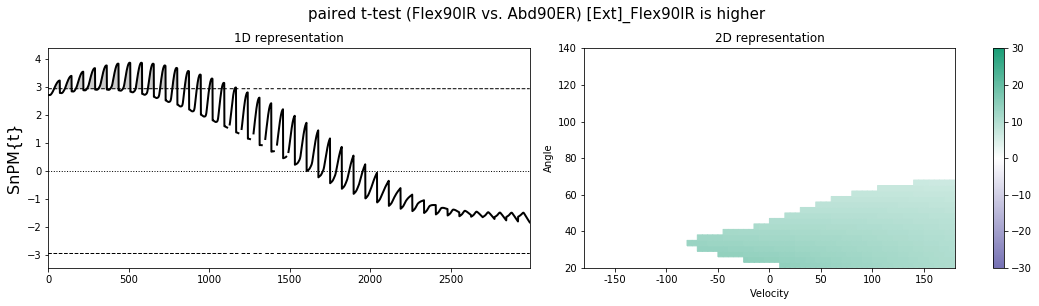

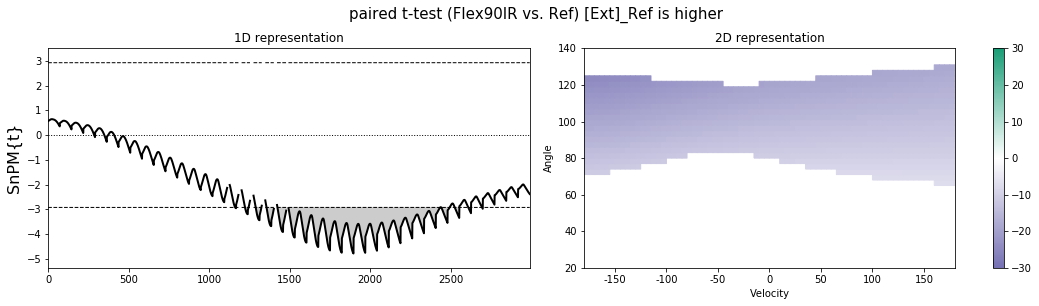

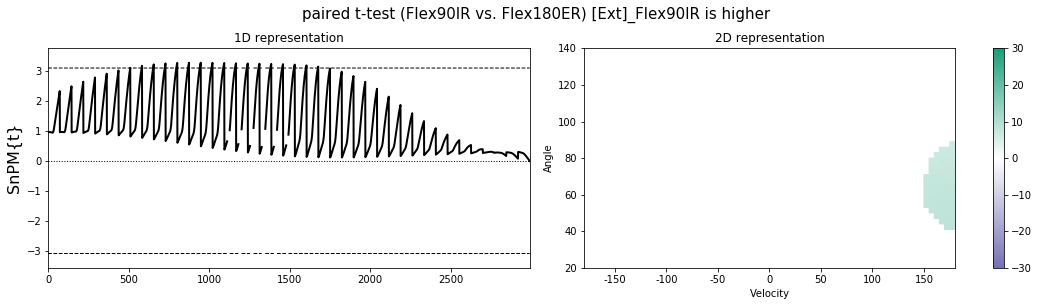

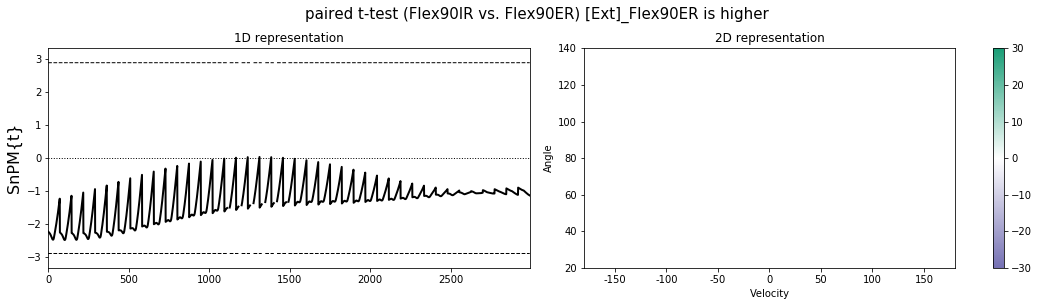

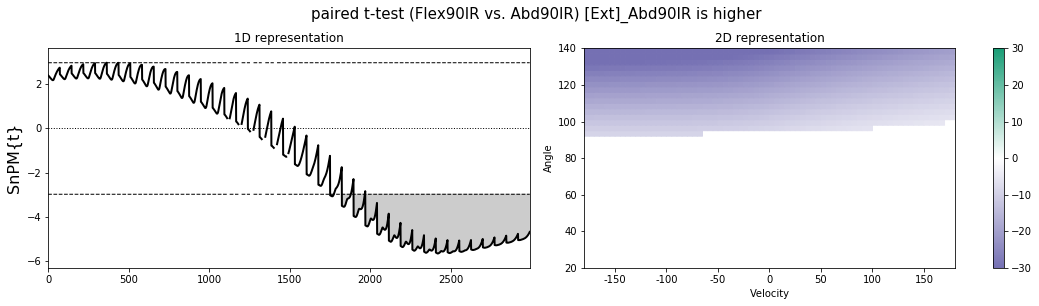

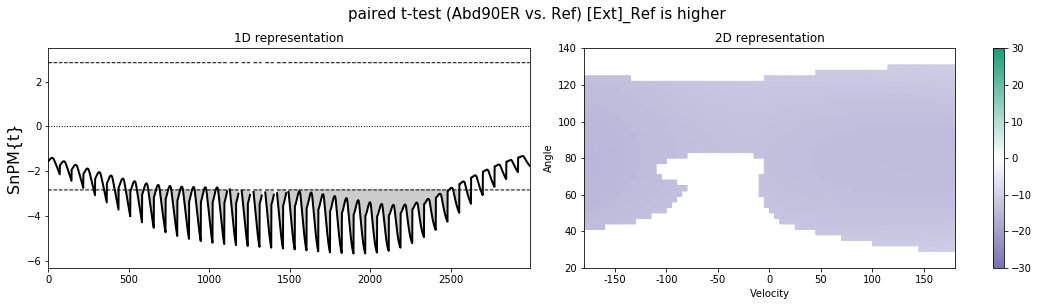

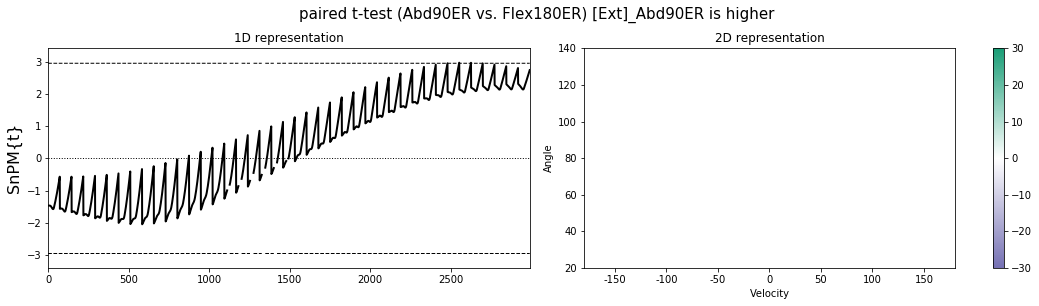

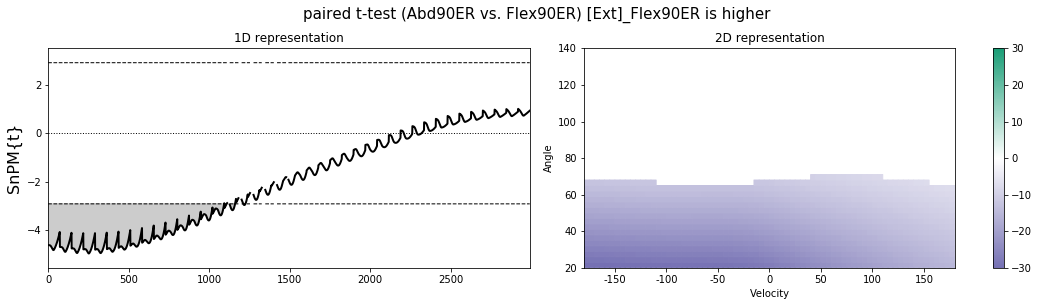

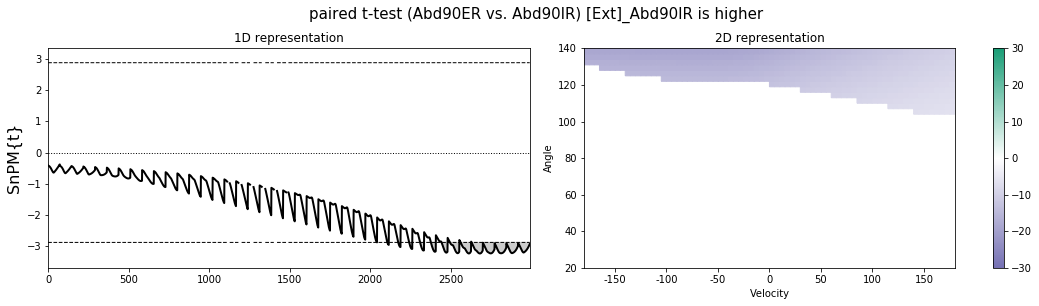

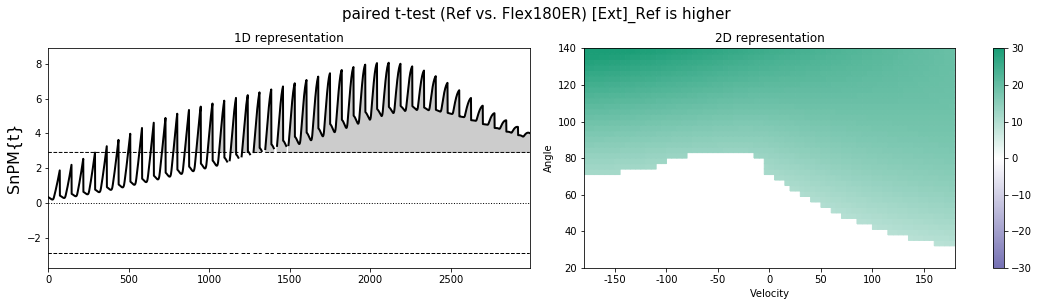

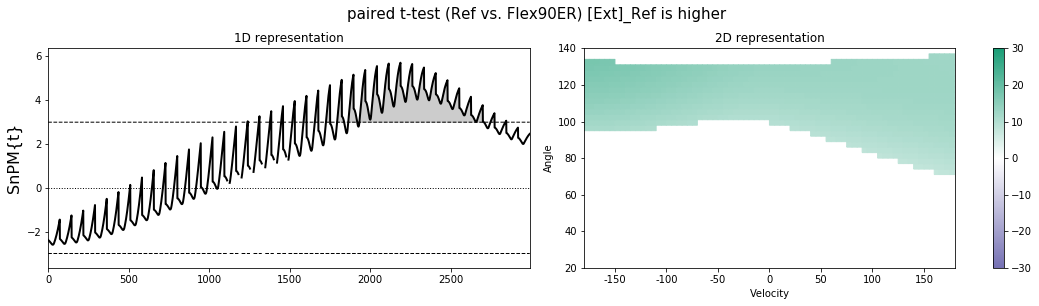

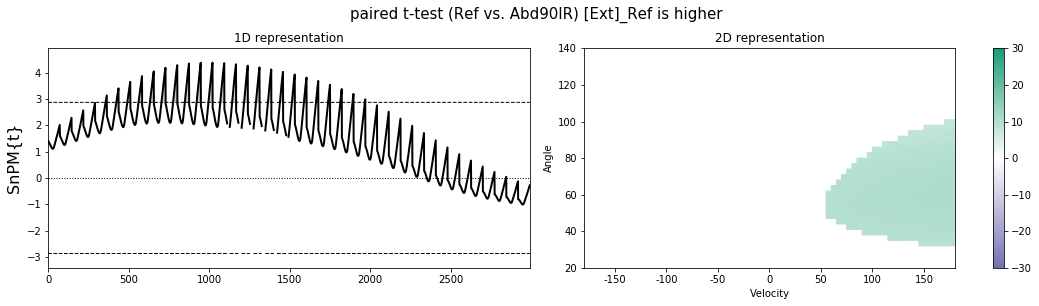

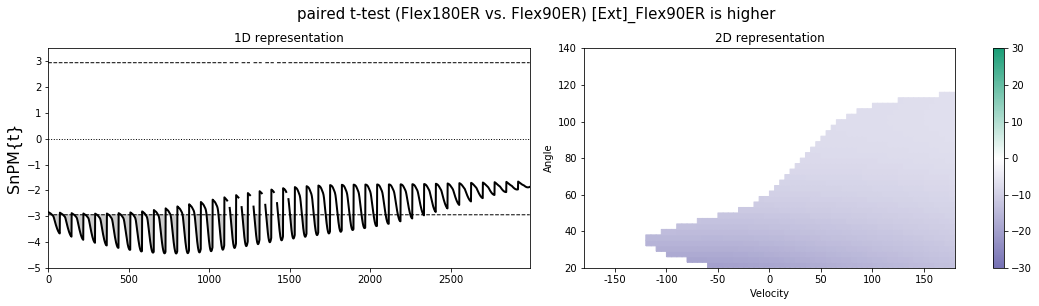

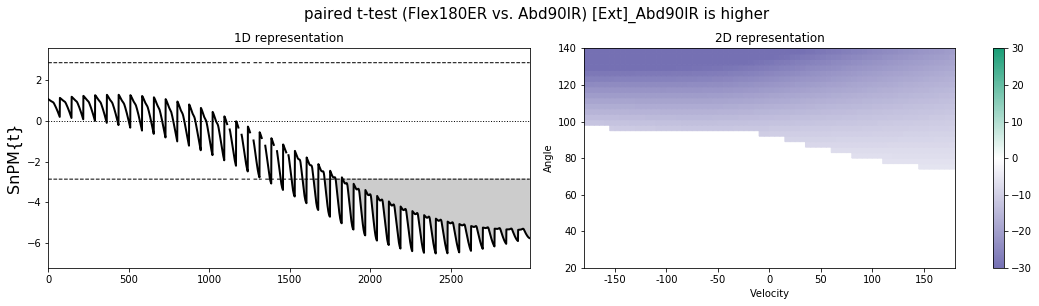

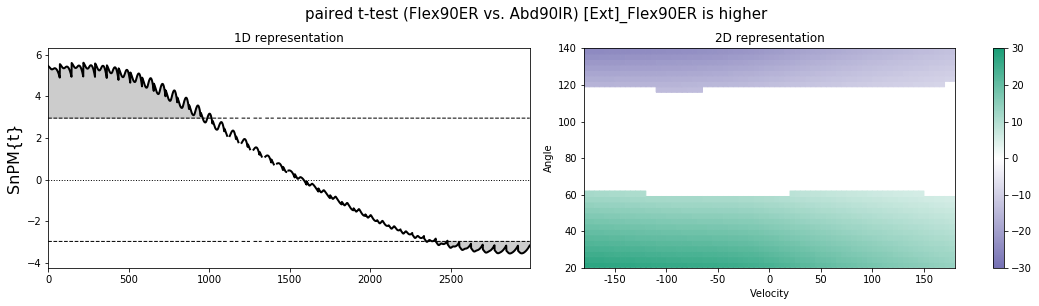

In [7]:
n_positions = len(set(positions))
name_positions = list(torque.keys())
combinations = itertools.combinations(range(0, n_positions), 2)

color_map = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#ffd92f', '#a6d854']
cmap = [] # 'by_position'

for A, B in combinations:
    yA = y[positions == A]
    yB = y[positions == B]
    
    if cmap == 'by_position':
        colors = [color_map[A], 'white', color_map[B]]
    else:
        colors = ['#7570b3', 'white', '#1b9e77']
    diff = np.mean(yA, axis=0) - np.mean(yB, axis=0)
    
    if np.mean(diff) > 0:
        higher = name_positions[A]
    else:
        higher = name_positions[B]
    
    t_spm = spm1d.stats.nonparam.ttest_paired(yA, yB, roi=roi)
    t_spmi = t_spm.inference(alpha, two_tailed=True, iterations=iterations, force_iterations=True)
    
    title = f'paired t-test ({name_positions[A]} vs. {name_positions[B]}) [{contraction}]_{higher} is higher'
    display_results(t_spmi, drop_non_significative=True, title=title,
                    print_result=False, save_fig=True,
                    colors=colors, diff=diff)